In [192]:
import os
import sys
import sys
# Path追加
sys.path.append('../')
import numpy as np
from mmdet.apis import init_detector, inference_detector

import cv2
import imageio
import matplotlib.pyplot as plt

from common.visulaizations import draw_bb
from data import Dataset


DATA_DIR = "../data/Problem_01"
RESULT_DIR = "../results/Problem_01"

dataset = Dataset(DATA_DIR, RESULT_DIR, fps=5)

# Detection (By Takenobu 2022/09/16)

In [6]:
# detection部分を関数化
def detection(img):
    config_path = '../configs/faster_rcnn_r50_fpn.py'
    weight_path = '../weights/latest.pth'
    

    model = init_detector(config_path, weight_path, device ='cuda:1')
    
    result_dir = '../results/nobu_result'

    score_th = 0.5

    #img = imageio.imread(img)
    result = inference_detector(model, img)
    
    return result

    '''
    det_img = draw_bb(img, result, score_th)
    det_img2 = cv2.cvtColor(det_img, cv2.COLOR_BGR2RGB)
    #plt.imshow(det_img2)
    cv2.imwrite(result_dir+os.path.basename(img_path), det_img)
    '''

# Try to make Object Tracking

In [7]:
import math
from turtle import color
import cv2

os.makedirs("../results/nobu_tracking", exist_ok=True)
# path to vidio
video_path = '../data/Problem_01/Problem_01.MP4'
cap = cv2.VideoCapture(video_path)
# Initialize Counter
count = 0
center_points_prev_frame = []

tracking_objects = {}
track_id = 0


while True:

    # Prepare for frame
    ret, frame = cap.read()

    # Point Current frame
    center_points_cur_frame = []    
    
    # If video is finished, escape from loop
    if not ret:
        break

    # Detection
    result = detection(frame)

    # Calculate the Center of detected fishes
    # each of loop is category of fish
    for category in result:
        # each of loop is data of detected fish
        for detected in category:
            x, y, x_w, y_h, score = detected[0:5]

            # Calculate center
            cx = int((x+x_w)/2)
            cy = int((y+y_h)/2)
            center_points_cur_frame.append((cx,cy))

            #cv2.circle(frame, (cx, cy), 10 , (0,0,255),-1)

    # Tracking
    # Only at the begining we compare previous and current freame
    if count <= 2:      
        for pt in center_points_cur_frame:
            for pt2 in center_points_prev_frame:
                # Calculate the distance between two points as Euclidean Distance
                distance = math.hypot(pt2[0]-pt[0], pt2[1]-pt2[1])
                # If distance is lower than 10, regard it as a same point
                if distance < 10:
                    tracking_objects[track_id] = pt
                    track_id += 1
    else:
        tracking_objects_copy = tracking_objects.copy()
        center_points_cur_frame_copy = center_points_cur_frame.copy()
           
        for object_id, pt2 in tracking_objects_copy.items():
            object_exits = False
            for pt in center_points_cur_frame:            
                distance = math.hypot(pt2[0]-pt[0], pt2[1]-pt2[1])
                # Update IDs position
                if distance < 30:
                    tracking_objects[object_id] = pt
                    object_exits = True
                    if pt in center_points_cur_frame:
                        center_points_cur_frame.remove(pt)
                        continue
            # Remove IDs lost
            if not object_exits:
                tracking_objects.pop(object_id)
    
        # Add new IDs found 
        for pt in center_points_cur_frame:
            tracking_objects[track_id] = pt
            track_id += 1


  
    for object_id, pt in  tracking_objects.items():
        cv2.circle(frame, pt, 5, (0,0, 255), -1)
        cv2.putText(frame, text=str(object_id), org=(pt[0], pt[1]-7), color=(0,0, 255),thickness=2,fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.0)

    print("Tracking Object")
    print(tracking_objects)

    print("CUR FRAME LEFT PT")
    print(center_points_cur_frame)
    
    # Make a copy of the points
    center_points_prev_frame = center_points_cur_frame.copy()

    count += 1

    # Debug
    
    frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame2)
    cv2.imwrite("../results/nobu_result/tracking_frame{}.png".format(count),frame)
    

    '''
    ## control the number of frames
    if count == 2:
        break
    '''

    # print(x,y,x_w,y_h,score)


cap.release()


load checkpoint from local path: ../weights/latest.pth


FileNotFoundError: ../weights/latest.pth can not be found.

## Video of Result 

In [ ]:
import cv2

img_dir = "../results/nobu_result"
# encoder(for mp4)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# output file name, encoder, fps, size(fit to image size)
video = cv2.VideoWriter('../results/tracking_video_test1.mp4',fourcc, 30.0, (1920, 1080))

for i in range(1,421):
    img_path = img_dir + "/tracking_frame{}.png".format(i)
    img = cv2.imread(img_path)
    print(img)
    video.write(img)

video.release()
print('written')

## Segmented fish based on binary image 
- 例えばColor histogramを元に魚領域をセグメンテーションして2値化

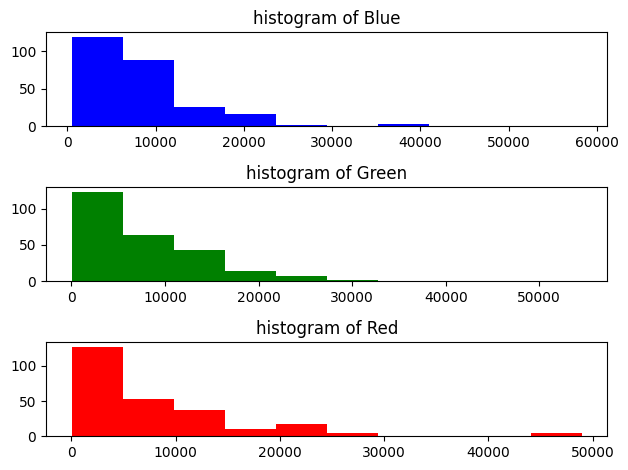

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../data/train/images/frame_000000.PNG")

blue_color = cv2.calcHist([img], [0], None, [256], [0, 256])
red_color = cv2.calcHist([img], [1], None, [256], [0, 256])
green_color = cv2.calcHist([img], [2], None, [256], [0, 256])


# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.hist(blue_color, color="blue")
 
plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.hist(green_color, color="green")
 
plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.hist(red_color, color="red")
 
# for clear view
plt.tight_layout()
plt.show()

In [40]:
def detection2(img):
    config_path = '../configs/faster_rcnn_r50_fpn.py'
    weight_path = '../weights/latest.pth'
    

    model = init_detector(config_path, weight_path, device ='cuda:1')
    
    result_dir = '../results/nobu_result'

    score_th = 0.5

    #img = imageio.imread(img)
    result = inference_detector(model, img)
    
    return result


load checkpoint from local path: ../weights/latest.pth


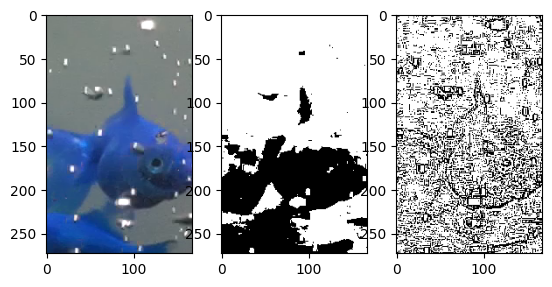

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

result = detection2(img)
# each of loop is category of fish
for category in result:
    # each of loop is data of detected fish
    for detected in category:
        x, y, x_w, y_h, score = detected[0:5]
        # integer 
        x, y, x_w, y_h = map(int,(x, y, x_w, y_h))

# crop image
crop_img = img[x:x_w, y:y_h]
im_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

# OTSU method 
ret, img_otsu = cv2.threshold(im_gray, 0, 255, cv2.THRESH_OTSU)

# adaptive threshold
img_adap = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 1)

# k-meas method
colors = crop_img.reshape(-1, 3).astype(np.float32)
K = 2
criteria = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0
ret, labels, centers = cv2.kmeans(colors, K, None, criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)
labels = labels.squeeze(axis=1)  # (N, 1) -> (N,)
centers = centers.astype(np.uint8)  # float32 -> uint8


f, axarr = plt.subplots(1,3)
axarr[0].imshow(crop_img)
axarr[1].imshow(img_otsu,cmap=plt.cm.gray)
axarr[2].imshow(img_adap,cmap=plt.cm.gray)



plt.show()


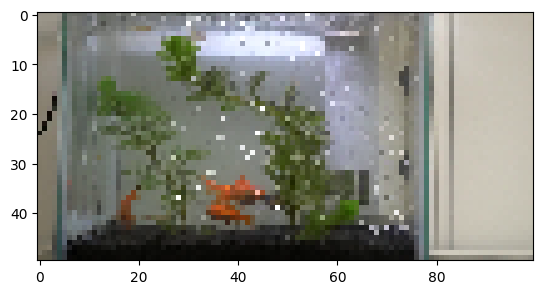

In [36]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread("../data/train/images/frame_000000.PNG")
img = cv2.resize(img, dsize=(100, 50))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

In [37]:
B = img[:,:,0]
G = img[:,:,1]
R = img[:,:,2]

print('B : ', B.shape)
print('G : ', G.shape)
print('R : ', R.shape)


B :  (50, 100)
G :  (50, 100)
R :  (50, 100)


In [38]:
print('B : ', type(B))

B :  <class 'numpy.ndarray'>


## 参考URL
https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

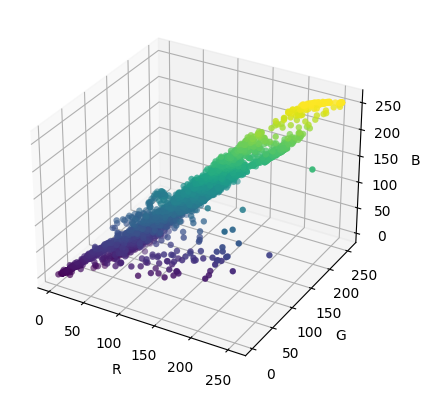

In [39]:
ax = plt.axes(projection='3d')
ax.scatter(R, G, B, c=B, cmap='viridis', linewidth=0.1)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B');

## ディテクションした部分でカラーヒストを表示

In [42]:
import os
import sys
import sys
# Path追加
sys.path.append('../')
import numpy as np
from mmdet.apis import init_detector, inference_detector

import cv2
import imageio
import matplotlib.pyplot as plt

from common.visulaizations import draw_bb
from data import Dataset


DATA_DIR = "../data/Problem_01"
RESULT_DIR = "../results/Problem_01"

dataset = Dataset(DATA_DIR, RESULT_DIR, fps=5)

In [175]:
from tkinter.tix import Tree
import cv2
import matplotlib.pyplot as plt

# Make images of Proble1

'''
saveimg_dir = "./nobu_TestImages"
video_path = "../data/Problem_01/Problem_01.MP4"

img_basename = "/problem1_"

cap = cv2.VideoCapture(video_path)

count = 0

while True:
   ret, frame = cap.read()
   if not ret:
      break
   count += 1
   cv2.imwrite(saveimg_dir+"/problem1_{}.png".format(count),frame)
'''    
    

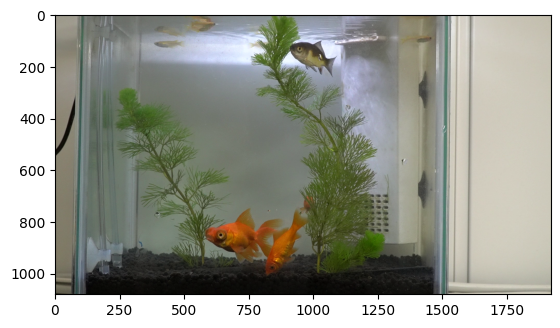

In [176]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("./nobu_TestImages/problem1_327.png")
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

load checkpoint from local path: ../weights/latest.pth
B :  (465, 249)
G :  (465, 249)
R :  (465, 249)


/home/workspace/kiyama/SummerCamp_2022_personal/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


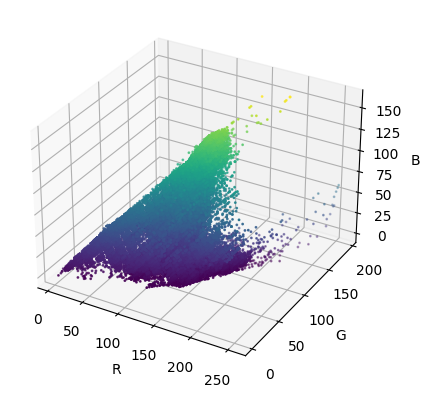

In [172]:

import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("./nobu_TestImages/problem1_327.png")
result = detection2(img)
'''
# each of loop is category of fish
for category in result:
    # each of loop is data of detected fish
    for detected in category:
        score = detected[4]
        # Set the TH(0.5)
        if score > 0.95:
            # integer 
            x, y, x_w, y_h = detected[0:4]
            x, y, x_w, y_h = map(int,(x, y, x_w, y_h))
'''
# crop image
category = result[4]
detected = category[0]
x, y, x_w, y_h, score= detected[0:5]
x, y, x_w, y_h = map(int,(x, y, x_w, y_h))


crop_img = img[x:x_w, y:y_h]

B = crop_img[:,:,0]
G = crop_img[:,:,1]
R = crop_img[:,:,2]

print('B : ', B.shape)
print('G : ', G.shape)
print('R : ', R.shape)

ax = plt.axes(projection='3d')
ax.scatter(R, G, B, c=B, s=1,cmap='viridis')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B');


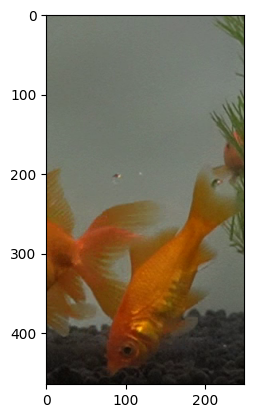

In [173]:
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
plt.imshow(crop_img)

In [174]:
for g in result:
    print(g.shape)

(5, 5)
(0, 5)
(4, 5)
(1, 5)
(1, 5)


# K-Meansを使って代表色を考える
- https://kikaben.com/k-means-clustering-of-image/


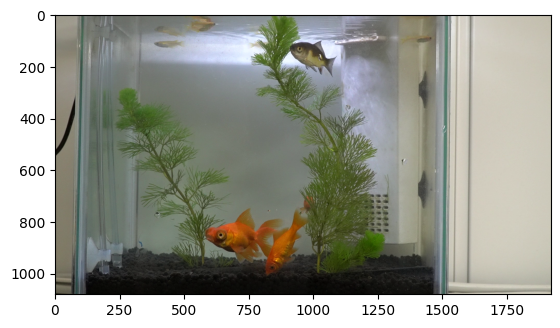

In [193]:
img = cv2.imread("./nobu_TestImages/problem1_327.png")
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

In [195]:
result = detection2(img)
for g in result:
    print(g.shape)

load checkpoint from local path: ../weights/latest.pth
(5, 5)
(0, 5)
(4, 5)
(1, 5)
(1, 5)


B :  (465, 249)
G :  (465, 249)
R :  (465, 249)


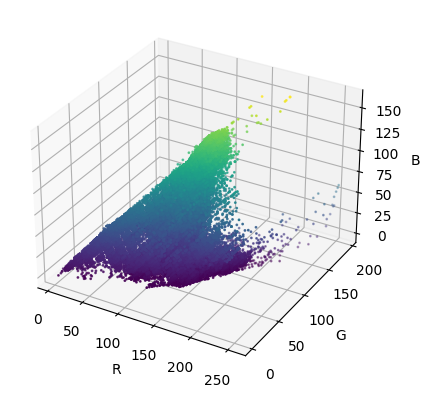

In [205]:
# crop image
category = result[4]
detected = category[0]


x, y, x_w, y_h, score= detected[0:5]
x, y, x_w, y_h = map(int,(x, y, x_w, y_h))


crop_img = img[x:x_w, y:y_h]

B = crop_img[:,:,0]
G = crop_img[:,:,1]
R = crop_img[:,:,2]

print('B : ', B.shape)
print('G : ', G.shape)
print('R : ', R.shape)

ax = plt.axes(projection='3d')
ax.scatter(R, G, B, c=B, s=1,cmap='viridis')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B');

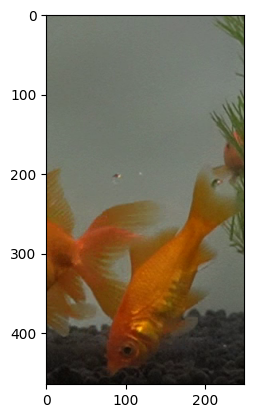

In [206]:
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
plt.imshow(crop_img)

In [207]:
print(img.shape)

h, w, c  = crop_img.shape
data_points = crop_img.reshape(h*w, c)
print('Flatten : ', data_points.shape)

(1080, 1920, 3)
Flatten :  (115785, 3)


In [208]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=2)
cluster_labels = kmeans_model.fit_predict(data_points)
print('Data Clustering : ', cluster_labels)
print(kmeans_model.cluster_centers_)

Data Clustering :  [0 0 0 ... 1 1 1]
[[117.06685453 120.82359503 107.94799877]
 [ 95.58140267  60.29186603  24.45995971]]


In [209]:
rgb_cols = kmeans_model.cluster_centers_.round(0).astype(int)
print('クラスター毎の代表的な色')
print(rgb_cols)

クラスター毎の代表的な色
[[117 121 108]
 [ 96  60  24]]


In [211]:
# Convert RGB to clustering(labeling) data
clustered_colors = rgb_cols[cluster_labels]
# Reshape (h, w, c)
clustered_image = np.reshape(clustered_colors, (h, w, c))
print(clustered_image.shape)

(465, 249, 3)


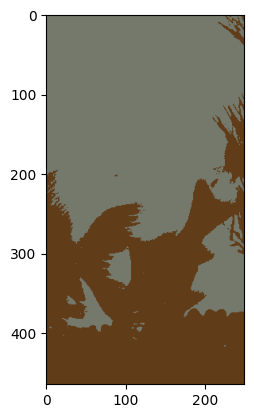

In [213]:
plt.imshow(clustered_image)